In [1]:
from transformers import pipeline
from PIL import Image
import numpy as np
import pandas as pd
import time
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
segmenter = pipeline("image-segmentation", model="mattmdjaga/segformer_b2_clothes")

Device set to use cpu


# Set up functions to Segment Clothes

In [3]:
# Initialize segmentation pipeline
def segment_clothing(img, clothes= ["Upper-clothes", "Pants", "Belt"]):
    # Segment image
    segments = segmenter(img)

    # Create list of masks
    mask_list = []
    for s in segments:
        if(s['label'] in clothes):
            mask_list.append(s['mask'])


    # Paste all masks on top of eachother 
    final_mask = np.array(mask_list[0])
    for mask in mask_list:
        current_mask = np.array(mask)
        final_mask = final_mask + current_mask
            
    # Convert final mask from np array to PIL image
    final_mask = Image.fromarray(final_mask)

    # Apply mask to original image
    img.putalpha(final_mask)

    # display the image
    return img

In [4]:
def batch_segment_clothing(img_dir, out_dir, clothes= ["Hat", "Upper-clothes", "Skirt", "Pants", "Dress", "Belt", "Left-shoe", "Right-shoe", "Scarf"]):
    # Create output directory if it doesn't exist
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    # Iterate through each file in the input directory
    for filename in os.listdir(img_dir):
        if filename.endswith(".jpg") or filename.endswith(".JPG") or filename.endswith(".png") or filename.endswith(".PNG"):
            try:
                # Load image
                img_path = os.path.join(img_dir, filename)
                img = Image.open(img_path).convert("RGBA")

                # Segment clothing
                segmented_img = segment_clothing(img, clothes)

                # Save segmented image to output directory as PNG
                out_path = os.path.join(out_dir, filename.split('.')[0] + ".png")
                segmented_img.save(out_path)

                print(f"Segmented {filename} successfully.")

            except Exception as e:
                print(f"Error processing {filename}: {e}")

        else:
            print(f"Skipping {filename} as it is not a supported image file.")

# scrape website and create csv file

In [5]:
from playwright.async_api import async_playwright

playwright = await async_playwright().start()

browser = await playwright.chromium.launch(headless=False)

page = await browser.new_page()

In [6]:
async def scroll_to_bottom(page):
    
    await page.evaluate("window.scrollTo(0, document.body.scrollHeight);")

##### Ralph_Lauren

In [7]:
RL_url = "https://www.ralphlauren.com/women-clothing-shop-new-arrivals" 
await page.goto(RL_url)

<Response url='https://www.ralphlauren.com/women-clothing-shop-new-arrivals' request=<Request url='https://www.ralphlauren.com/women-clothing-shop-new-arrivals' method='GET'>>

In [8]:
await page.wait_for_selector('button .ui-button-icon.ui-icon.ui-icon-closethick', state='visible', timeout=30000)
await page.click('button .ui-button-icon.ui-icon.ui-icon-closethick')

In [9]:
RL = []
try:
    rl = await page.eval_on_selector_all(
        "[srcset]",
        "elements => elements.map(el => el.getAttribute('srcset'))"
    )
    RL.extend(rl)

except:
    print('done')

#### Uniqlo

In [10]:
uniqlo='https://www.uniqlo.com/us/en/feature/new/women'
await page.goto(uniqlo)
await scroll_to_bottom(page)
await page.wait_for_timeout(1000)
unq= await page.eval_on_selector_all(
    "div.fr-ec-product-tile-resize-wrapper img.fr-ec-image__img",
    "elements => elements.map(e => e.src)"
)

### Zara

In [11]:
Zara = "https://www.zara.com/us/en/woman-best-sellers-l5912.html?v1=2491343&regionGroupId=41"
await page.goto(Zara)
await page.locator("body").wait_for()
last_height = await page.evaluate("document.body.scrollHeight")
try:
    while True:
        await page.evaluate("window.scrollTo({left: 0, top: document.body.scrollHeight, behavior: 'smooth'})")
        await page.wait_for_load_state("networkidle", timeout=5000)
        await page.wait_for_timeout(2000)
        new_height = await page.evaluate("document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height
except:
    print('done')

In [12]:
zara = await page.eval_on_selector_all(
    'img[data-qa-qualifier="media-image"]',
            "elements => elements.map(e => e.src)"
        )
zara = [e for e in zara if 'background' not in e]

### HM

In [13]:
hm = "https://www2.hm.com/en_us/women/new-arrivals/view-all.html"
await page.goto(hm)

<Response url='https://www2.hm.com/en_us/women/new-arrivals/view-all.html' request=<Request url='https://www2.hm.com/en_us/women/new-arrivals/view-all.html' method='GET'>>

In [14]:
all_links = []
try:
    while True:
            hm = await page.eval_on_selector_all(
                'img[imagetype="PRODUCT_IMAGE"]',
                "elements => elements.map(e => e.srcset)"
            )
            all_links.extend(hm)
    
            next_button = await page.query_selector('button[data-elid="pagination-hybrid-button"]')
            if next_button:
                await next_button.click(timeout=6000)
            else:
                break
except:
    print('done')

done


In [15]:
hm = [h.split(', ')[-1] for h in all_links if len(h)>10]
hm = [h.split(' ')[0] for h in hm]

### Forever21

## Make a dataframe

In [16]:
links=[]
d = pd.DataFrame({'ExistingColumn': range(100)})

In [17]:
def adjust_length(values, target_length):
    if len(values) < target_length:
        return values + ['N/A'] * (target_length - len(values))
    else:
        return values[:target_length]

In [18]:
rl_extended = adjust_length(RL, len(d))
unq_extended = adjust_length(unq, len(d))
zara_extended = adjust_length(zara, len(d))
hm_extended = adjust_length(hm, len(d))

d['Ralph_Lauren'] = rl_extended
d['Uniqlo'] = unq_extended
d['Zara'] = zara_extended
d['HM'] = hm_extended

links.append(d)

In [19]:
d.drop(columns='ExistingColumn', errors='ignore', inplace=True)
d.to_csv('Image_Sources.csv',index=False)

In [20]:
d.head()

,Ralph_Lauren,Uniqlo,Zara,HM
0,https://dtcralphlauren.scene7.com/is/image/Pol...,https://image.uniqlo.com/UQ/ST3/us/imagesgoods...,https://static.zara.net/assets/public/471b/890...,https://image.hm.com/assets/hm/cf/5d/cf5dd1631...
1,https://dtcralphlauren.scene7.com/is/image/Pol...,https://image.uniqlo.com/UQ/ST3/WesternCommon/...,https://static.zara.net/assets/public/f8b9/728...,https://image.hm.com/assets/hm/44/80/44807a87b...
2,https://dtcralphlauren.scene7.com/is/image/Pol...,https://image.uniqlo.com/UQ/ST3/us/imagesgoods...,https://static.zara.net/assets/public/3b71/493...,https://image.hm.com/assets/hm/61/f7/61f702eff...
3,https://dtcralphlauren.scene7.com/is/image/Pol...,https://image.uniqlo.com/UQ/ST3/us/imagesgoods...,https://static.zara.net/assets/public/5fa6/ff3...,https://image.hm.com/assets/hm/f7/67/f767271cc...
4,https://dtcralphlauren.scene7.com/is/image/Pol...,https://image.uniqlo.com/UQ/ST3/us/imagesgoods...,https://static.zara.net/assets/public/f1b0/f7d...,https://image.hm.com/assets/hm/3a/e5/3ae59326a...


# Read url from the csv file & Segmentation

In [21]:
import urllib.request
from urllib.parse import unquote, urlparse
import re
import os

In [22]:
d = pd.read_csv('Image_Sources.csv')

In [23]:
d.head()

,Ralph_Lauren,Uniqlo,Zara,HM
0,https://dtcralphlauren.scene7.com/is/image/Pol...,https://image.uniqlo.com/UQ/ST3/us/imagesgoods...,https://static.zara.net/assets/public/471b/890...,https://image.hm.com/assets/hm/cf/5d/cf5dd1631...
1,https://dtcralphlauren.scene7.com/is/image/Pol...,https://image.uniqlo.com/UQ/ST3/WesternCommon/...,https://static.zara.net/assets/public/f8b9/728...,https://image.hm.com/assets/hm/44/80/44807a87b...
2,https://dtcralphlauren.scene7.com/is/image/Pol...,https://image.uniqlo.com/UQ/ST3/us/imagesgoods...,https://static.zara.net/assets/public/3b71/493...,https://image.hm.com/assets/hm/61/f7/61f702eff...
3,https://dtcralphlauren.scene7.com/is/image/Pol...,https://image.uniqlo.com/UQ/ST3/us/imagesgoods...,https://static.zara.net/assets/public/5fa6/ff3...,https://image.hm.com/assets/hm/f7/67/f767271cc...
4,https://dtcralphlauren.scene7.com/is/image/Pol...,https://image.uniqlo.com/UQ/ST3/us/imagesgoods...,https://static.zara.net/assets/public/f1b0/f7d...,https://image.hm.com/assets/hm/3a/e5/3ae59326a...


In [24]:
path_files=[]
dic={}
for col in d.columns:
    links=d[col].head(30)
    # Create a folder for the current column
    os.makedirs(col, exist_ok=True)
    paths=[]
     
    for l in links:
        try:
            # URL of the file to download
            url = l

            # Extract the filename from the URL
            filename = url.split("/")[-1]  # Default fallback if Content-Disposition is not available
            filename = unquote(filename)  # Decode URL-encoded characters in the filename

            # Combine column name folder path with filename
            filepath = os.path.join(col, filename)

            # Define custom headers
            headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

            # Create a request object with headers
            request = urllib.request.Request(url, headers=headers)

            # Download and save the file
            try:
                with urllib.request.urlopen(request) as response, open(filepath, 'wb') as file:
                    file.write(response.read())

            except urllib.error.HTTPError as e:
                print(f"HTTPError: {e.code} - {e.reason}")
            except Exception as e:
                print(f"Error: {e}")           
            
            # urllib.request.urlretrieve(url, filepath)            
            time.sleep(1)
                        
            # open the file
            image=Image.open(filepath)

            # segment the clothes
            result = segment_clothing(img=image)
            result.save(f'{filepath}.png')
            paths.append(f'{filepath}.png')
    
        except Exception as e:
            print("This image cound't be found:",l)
            print(e)

    dic[col]=paths
    path_files.append(dic)

This image cound't be found: https://dtcralphlauren.scene7.com/is/image/PoloGSI/s7-AI211959908001_alternate1?$plpDeskRF$
list index out of range


This image cound't be found: https://dtcralphlauren.scene7.com/is/image/PoloGSI/s7-AI211959908001_alternate1?$plpMob$
list index out of range


This image cound't be found: https://dtcralphlauren.scene7.com/is/image/PoloGSI/s7-AI211959051001_lifestyle?$plpDeskRF$
list index out of range


This image cound't be found: https://dtcralphlauren.scene7.com/is/image/PoloGSI/s7-AI211959051001_lifestyle?$plpMob$
list index out of range


This image cound't be found: https://static.zara.net/assets/public/72d4/f73f/5fb14522bdcb/ffefdd43d9be/02180303800-p/02180303800-p.jpg?ts=1733411240151&w=548
list index out of range


This image cound't be found: https://static.zara.net/assets/public/b0ce/f421/759e4fbcb88d/fcf2ea45d766/03152304791-a1/03152304791-a1.jpg?ts=1733411241313&w=548
list index out of range


This image cound't be found: https://image.hm.com/assets/hm/26/42/26428bd3d935b2507eda2176003b2dd984b8f7db.jpg?imwidth=1536
list index out of range


This image cound't be found: https://image.hm.com/assets/hm/20/0d/200d054b75a2290ab2ec5c9c5ff2213417b78cd2.jpg?imwidth=1536
list index out of range


This image cound't be found: https://image.hm.com/assets/hm/32/b4/32b409aa1c461ef389863b5dc6080c1cb004909a.jpg?imwidth=1536
list index out of range


# read the colors

In [25]:
# pip install Pillow scikit-learn

In [26]:
def extract_colors(image_path, num_colors=5):
    img = Image.open(image_path)
    # Ensure image is in RGB format
    img = img.convert('RGB')
    
    img = img.resize((256, 256))  # Resize for faster processing
    img_array = np.array(img)
    img_array = img_array.reshape((-1, 3))

    kmeans = KMeans(n_clusters=num_colors)
    kmeans.fit(img_array)
    colors = kmeans.cluster_centers_.astype(int)
    return colors

# Make a color palette

In [27]:
def luminance(color):
    r, g, b = color
    return 0.299 * r + 0.587 * g + 0.114 * b

In [28]:
palettes = []
for brand, paths in path_files[0].items():
    image_paths = paths  
    
    if not image_paths:
        print(f"No image paths for {brand}")
        continue
    
    all_colors = []
    
    try:
        for path in image_paths:
            colors = extract_colors(path)
            all_colors.extend(colors)
        
        if not all_colors:
            print(f"No colors extracted for {brand}")
            continue
        
        all_colors = sorted(all_colors, key=luminance)
        final_palette = KMeans(n_clusters=10).fit(all_colors).cluster_centers_.astype(int)
        palettes.append(final_palette)
        
        # Create a plot for each brand's palette
        plt.figure(figsize=(10, 2))
        plt.axis('off')
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        
        # Plot color squares
        for i, color in enumerate(final_palette):
            plt.fill([i, i+1, i+1, i], [0, 0, 1, 1], color=color/255.0)
        
        plt.savefig(f'{brand}.png', transparent=True, bbox_inches='tight', pad_inches=0)
        plt.close()  # Close the figure to free up memory
    
    except Exception as e:
        print(f"{brand} has an error: {e}")

print(f"Total palettes generated: {len(palettes)}")

Total palettes generated: 4


I consult google for this

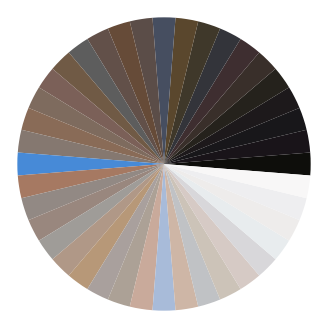

In [29]:
# Convert the final palette to a usable color format
final_colors = [tuple(color / 255) for palette in palettes for color in palette]  
final_colors = sorted(final_colors, key=luminance)

# Number of colors
num_colors = len(final_colors)

# Angles
angles = np.linspace(0, 2 * np.pi, num_colors, endpoint=False)

# Create a polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))
bars = ax.bar(angles, np.ones(num_colors), color=final_colors, width=2 * np.pi / num_colors)

# Remove radial and angular ticks
ax.set_yticks([])
ax.set_xticks([])
ax.spines['polar'].set_visible(False)

plt.savefig('color_wheel.png', transparent=True)

# Find the most commonly appeared color

In [30]:
from collections import Counter

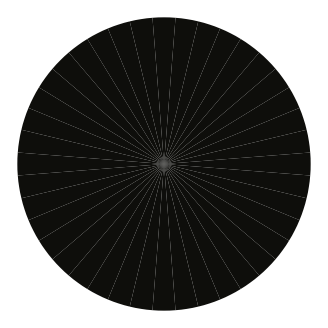

In [31]:
color_counts = Counter(final_colors)
most_common_color, _ = color_counts.most_common(1)[0]

fig2, ax2 = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))
ax2.bar(angles, np.ones(num_colors), color=[most_common_color] * num_colors, width=2 * np.pi / num_colors)


ax2.set_yticks([])
ax2.set_xticks([])
ax2.spines['polar'].set_visible(False)

plt.savefig('most_common_color_wheel.png', transparent=True)

# Build a color count table

In [32]:
if os.path.exists("latest_color_grids.png"):
    # Rename the existing file
    os.rename("latest_color_grids.png", "last_grids.png")

In [33]:
import math
total_colors = len(final_colors)
cols = math.ceil(math.sqrt(total_colors))  # Number of columns
rows = math.ceil(total_colors / cols)    

In [34]:
rows = 9
cols = 10

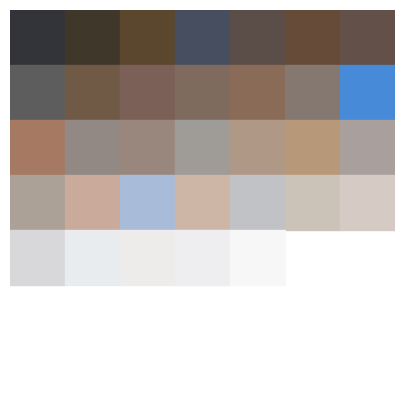

In [35]:
num_colors = len(final_colors)
rows = int(np.ceil(np.sqrt(num_colors)))
cols = rows

# Create the grid plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.axis('off')  # Turn off axes

# Create the grid
for idx, color in enumerate(final_colors):
    row = idx // cols
    col = idx % cols
    ax.add_patch(plt.Rectangle((col, -row), 1, 1, color=color))

# Set the aspect and limits to make a square grid
ax.set_xlim(0, cols)
ax.set_ylim(-rows, 0)
ax.set_aspect('equal')

plt.savefig('latest_color_grids.png', transparent=True)

# create an color grid html

In [36]:
colors = [color for palette in palettes for color in palette]
# Generate HTML
html_content = "<!DOCTYPE html>\n<html>\n<head>\n<style>\n"
html_content += """
.grid-container {
    display: grid;
    grid-template-columns: repeat(auto-fill, 60px);
    gap: 5px;
}
.grid-item {
    width: 60px;
    height: 60px;
    display: flex;
    justify-content: center;
    align-items: center;
    font-size: 10px;
    color: black;
    border: 1px solid #ccc;
    text-shadow: 0 0 2px white; 
}
</style>
</head>\n<body>\n<div class="grid-container">\n"""

for index, color in enumerate(colors, 1):
    rgb_value = f"rgb({color[0]}, {color[1]}, {color[2]})"
    html_content += f'    <div class="grid-item" style="background-color: {rgb_value};">{color}</div>\n'
    
    # Add a line break after every 10 items
    if index % 10 == 0:
        html_content += '</div>\n<div class="grid-container">\n'

if len(colors) % 10 != 0:
    html_content += '</div>\n'
    
html_content += "</div>\n</body>\n</html>"

# Save to an HTML file
with open("color_grids.html", "w") as f:
    f.write(html_content)

print("HTML file generated: color_grid.html")

HTML file generated: color_grid.html
